# Analyse data and results for Persuasion Spans



In [1]:
import pandas as pd
import numpy as np
import json
from collections import Counter
import spacy
import seaborn as sns

In [2]:
nlp = spacy.load('en_core_web_sm')

In [3]:
def style_cell_background(cell_value):
    """Hide 0.0-values and mark negative values"""
    hide = 'color: transparent'
    decreased = 'color: red'
    default = ''

    if type(cell_value) in [float]:
        if cell_value == 0.0:
            return hide
        elif cell_value < 0.0:
            return decreased
    elif cell_value is None or cell_value == '':
        return hide
    
    return default

# Read and display evaluation results

We have results for two `suggesters`: 
* 16-grams
* 32-grams
    
and three models:
* sm (small)
* lg (large)
* trf (transformer)
    

In [4]:
def read_metrics(fpath, index_name):
    """Read metrics in CSV format created by reports.py from JSON metrics"""
    df = pd.read_csv(fpath)
    df = df.set_index(df.columns[0])
    df.index.name = index_name
    return df

## Total results

In [5]:
totals16 = read_metrics('metrics/totals_16.csv', 'metric:').T
totals32 = read_metrics('metrics/totals_32.csv', 'metric:').T

totals = pd.concat([totals16, totals32],keys= ['16-grams', '32-grams'],names=['n-grams:', 'model:'], axis=1)
totals_copy = totals.copy()

# Make all 32-grams values that are lower than the corresponding 16-grams values negative
for m in ['sm', 'lg', 'trf']:
        totals[('32-grams', m)] = np.sign(totals[('32-grams', m)] - totals[('16-grams', m)]) * totals[('32-grams', m)]

# Format: absolute value and three decimals
totals_style = totals.style.format(lambda x: f'{abs(x):.3f}')
totals_style.set_table_styles([
    {'selector': 'th.col_heading', 'props': 'text-align: center;'},
    {'selector': 'td:hover', 'props': [('background-color', '#ffffb3')]},
    {'selector': 'th.col_heading.level0', 'props': 'font-size: 1.5em;'},
    {'selector': 'th.col_heading.level1', 'props': 'font-size: 1.2em;'},
    {'selector': '.index_name','props': 'font-style: italic; color: darkgrey; font-weight:bold; font-size: 1.3em'},
    {'selector': 'th', 'props': 'background-color: #000066; color: white;'}
], overwrite=False)

# Draw vertical line (border) left of 32-grams level0 block
totals_style.set_table_styles({('32-grams','sm'): [
    {'selector': 'th', 'props': 'border-left: 1px solid white'},
    {'selector': 'td', 'props': 'border-left: 1px solid #000066'}
    ]}, overwrite=False, axis=0)
totals_style.applymap(style_cell_background)
totals_style

In [6]:
df = totals_copy.unstack(level=0).reset_index()
df.columns = ['n-grams', 'model', 'metric', 'value']
df = df[ df['metric'] == 'f1']
df

,n-grams,model,metric,value
2,16-grams,sm,f1,0.104384
5,16-grams,lg,f1,0.150289
8,16-grams,trf,f1,0.245552
11,32-grams,sm,f1,0.070640
14,32-grams,lg,f1,0.184162
17,32-grams,trf,f1,0.252427


<AxesSubplot:xlabel='model', ylabel='f1'>

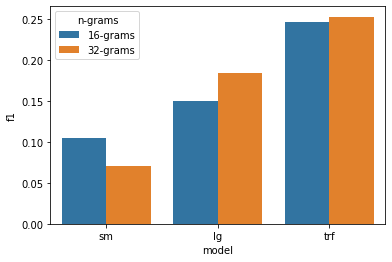

In [7]:
df = totals_copy.unstack(level=0).reset_index()
df.columns = ['n-grams', 'model', 'metric', 'value']
df = df[ df['metric'] == 'f1']
df = df.drop(columns=['metric'])
df.columns = ['n-grams', 'model', 'f1']
sns.barplot(x="model", y='f1', hue="n-grams", data=df)

## Results per persuasion technique

In [8]:
per_label16 = read_metrics('metrics/per_label_16.csv', 'persuasion technique')
per_label32 = read_metrics('metrics/per_label_32.csv', 'persuasion technique')

per_label = pd.concat([per_label16, per_label32], keys= ['16-grams', '32-grams'],axis=1, names=['n-grams:','model:'])

# Make all 32-grams values that are lower than the corresponding 16-grams values negative
for m in ['sm', 'lg', 'trf']:
        per_label[('32-grams', m)] = np.sign(per_label[('32-grams', m)] - per_label[('16-grams', m)]) * per_label[('32-grams', m)]
    
# Format: absolute value and three decimals
per_label = per_label.style.format(lambda x: f'{abs(x):.3f}')
per_label.set_table_styles([
    {'selector': 'th.col_heading', 'props': 'text-align: center;'},
    {'selector': 'td:hover', 'props': [('background-color', '#ffffb3')]},
    {'selector': 'th.col_heading.level0', 'props': 'font-size: 1.5em;'},
    {'selector': '.index_name','props': 'font-style: italic; color: darkgrey; font-weight:bold; font-size: 1.3em'},
    {'selector': 'th', 'props': 'background-color: #000066; color: white;'}
])

# Draw vertical line (border) left of 32-grams level0 block
per_label.set_table_styles({('32-grams','sm'): [
    {'selector': 'th', 'props': 'border-left: 1px solid white'},
    {'selector': 'td', 'props': 'border-left: 1px solid #000066'}
    ]}, overwrite=False, axis=0)
per_label.applymap(style_cell_background)
per_label


# Data

In [9]:
c = Counter()
wc = Counter()
cutoff8 = Counter()
cutoff_8_limit = 8
cutoff16 = Counter()
cutoff_16_limit = 16
cutoff32 = Counter()
cutoff_32_limit = 32
fnames = ['training_set_task2.txt', 'dev_set_task2.txt', 'test_set_task2.txt']
total_spans = 0
for fname in fnames:
    with open(f'assets/{fname}','r') as f:
        obj = json.load(f)
        print(f"number of records in {fname}: ", len(obj))
        for record in obj:
            labels = record['labels']
            for l in labels:
                total_spans += 1
                technique = l['technique']
                c[technique] += 1
                # We do *not* remove interpunction and whitespace tokens, because the n-gram suggester 
                # doesn't do so either.
                words = [x for x in nlp(l['text_fragment'])]
                wc[technique] += len(words)
                if len(words) > cutoff_8_limit:
                    cutoff8[technique] += 1
                if len(words) > cutoff_16_limit:
                    cutoff16[technique] += 1
                if len(words) > cutoff_32_limit:
                    cutoff32[technique] += 1
                
# Add missing techniques to cutoff counters
for t in c.keys():
    if not cutoff8[t]:
        cutoff8[t] = 0
    if not cutoff16[t]:
        cutoff16[t] = 0
    if not cutoff32[t]:
        cutoff32[t] = 0

print("Total spans in dataset: ", total_spans)

number of records in training_set_task2.txt:  688
number of records in dev_set_task2.txt:  63
number of records in test_set_task2.txt:  200
Total spans in dataset:  2083


## Data: occurences and span lengths per class

In [10]:
x = c.most_common()

ndf = pd.DataFrame({'Persuasion technique': [k[0] for k in x], 
                    'Occurrences': [k[1] for k in x], 
                    'Avg tokens': [wc[k[0]]/k[1] for k in x]
                   })

# Format: absolute value and three decimals
ndf = ndf.set_index('Persuasion technique')
per_label = ndf.style.format(formatter={'Avg tokens': "{:.1f}"})
per_label.set_table_styles([
    {'selector': 'th.col_heading', 'props': 'text-align: center;'},
    {'selector': 'td:hover', 'props': [('background-color', '#ffffb3')]},
    {'selector': '.index_name','props': 'font-style: italic; color: darkgrey; font-weight:bold; font-size: 1.3em'},
    {'selector': 'th', 'props': 'background-color: #000066; color: white;'},
])

per_label

,Occurrences,Avg tokens
Persuasion technique,,
Loaded Language,761,2.6
Name calling/Labeling,408,2.9
Smears,266,20.5
Doubt,86,15.9
Exaggeration/Minimisation,85,7.4
Slogans,72,5.7
Appeal to fear/prejudice,60,11.4
Whataboutism,54,26.4
Glittering generalities (Virtue),45,16.6


## Data: how many samples don't fit the maximum of the `suggester`?

We have somewhat arbitrarily chosen 16-grams and 32-grams suggesters, meaning that only sequences of tokens up to respectively 16 and 32 tokens are considered. Any sample with a span length longer than the maximum defined by the suggester will not be covered.

We will now display how many samples and of what techniques will fall outside the range of the used suggesters.

### Overview of lengths of span samples

For quick insight we highlight values in the table below with arbitrarily set limits:

Legend:
* red (bad): value > 30%
* low opacity (good): value < 10%

In [11]:
x = c.most_common()

ndf = pd.DataFrame({'Persuasion technique': [k[0] for k in x], 
                    'Occurrences': [k[1] for k in x], 
                    'Avg tokens': [wc[k[0]]/k[1] for k in x],
                    'Cut off 8': [cutoff8[k[0]] for k in x],
                    '% Cut off 8': [100*cutoff8[k[0]]/k[1] for k in x],
                    'Cut off 16': [cutoff16[k[0]] for k in x],
                    '% Cut off 16': [100*cutoff16[k[0]]/k[1] for k in x],
                    'Cut off 32': [cutoff32[k[0]] for k in x],
                    '% Cut off 32': [100*cutoff32[k[0]]/k[1] for k in x]
                   })

# Format: absolute value and three decimals
ndf = ndf.set_index('Persuasion technique')
per_label = ndf.style.format(formatter={'Avg tokens': "{:.1f}", '% Cut off 8': "{:.0f}%", '% Cut off 16': "{:.0f}%",'% Cut off 32': "{:.0f}%"})
per_label.set_table_styles([
    {'selector': 'th.col_heading', 'props': 'text-align: center;'},
    {'selector': 'td:hover', 'props': [('background-color', '#ffffb3')]},
    {'selector': '.index_name','props': 'font-style: italic; color: darkgrey; font-weight:bold; font-size: 1.3em'},
    {'selector': 'th', 'props': 'background-color: #000066; color: white;'},
])
def style_large(v, props=''):
    return props if v > 30 else None
slice = ['% Cut off 8', '% Cut off 16', '% Cut off 32']
per_label.applymap(style_large, props='color:red;', subset=slice)\
         .applymap(lambda v: 'opacity: 30%;' if (v < 10) else None, subset=slice)

# Draw vertical line (border) left of 32-grams level0 block
per_label.set_table_styles({
    'Cut off 8': [
        {'selector': 'th', 'props': 'border-left: 1px solid white'},
        {'selector': 'td', 'props': 'border-left: 1px solid #000066'}
    ],
    'Cut off 16': [
        {'selector': 'th', 'props': 'border-left: 1px solid white'},
        {'selector': 'td', 'props': 'border-left: 1px solid #000066'}
    ],
    'Cut off 32': [
        {'selector': 'th', 'props': 'border-left: 1px solid white'},
        {'selector': 'td', 'props': 'border-left: 1px solid #000066'}
    ],
    }, overwrite=False, axis=0)


per_label


,Occurrences,Avg tokens,Cut off 8,% Cut off 8,Cut off 16,% Cut off 16,Cut off 32,% Cut off 32
Persuasion technique,,,,,,,,
Loaded Language,761,2.6,31,4%,6,1%,3,0%
Name calling/Labeling,408,2.9,11,3%,1,0%,0,0%
Smears,266,20.5,230,86%,139,52%,40,15%
Doubt,86,15.9,69,80%,30,35%,6,7%
Exaggeration/Minimisation,85,7.4,29,34%,5,6%,0,0%
Slogans,72,5.7,8,11%,2,3%,1,1%
Appeal to fear/prejudice,60,11.4,34,57%,14,23%,1,2%
Whataboutism,54,26.4,54,100%,43,80%,11,20%
Glittering generalities (Virtue),45,16.6,33,73%,17,38%,5,11%


In [12]:
x = c.most_common()

data = []

for k in x:
    data.append([
        k[1],  # occurrences
        wc[k[0]]/k[1],  # avg tokens
        cutoff8[k[0]],   # total cut off for 8-grams
        100*cutoff8[k[0]]/k[1], # % cut off for 8-grams
        cutoff16[k[0]],   # total cut off for 16-grams
        100*cutoff16[k[0]]/k[1], # % cut off for 16-grams
        cutoff32[k[0]],   # total cut off for 32-grams
        100*cutoff32[k[0]]/k[1], # % cut off for 32-grams
    ])

ndf = pd.DataFrame(data,
                  index=pd.Index([k[0] for k in x], name='Persuasion technique:'),
                  columns=pd.MultiIndex.from_tuples(
                      [('Overview', 'Occurrences'),('Overview','Avg tokens'),
                       ('8-grams cut', 'total'), ('8-grams cut', '%'),
                       ('16-grams cut', 'total'), ('16-grams cut', '%'),
                       ('32-grams cut', 'total'), ('32-grams cut', '%')
                      ],
                      names=[' ', ' '])
            )

per_label = ndf.style.format(formatter={
    ('Overview', 'Avg tokens'): "{:.1f}", 
    ('8-grams cut', '%'): "{:.0f}%", 
    ('16-grams cut', '%'): "{:.0f}%", 
    ('32-grams cut', '%'): "{:.0f}%"
})
per_label.set_table_styles([
    {'selector': 'th.col_heading.level0', 'props': 'text-align: center;'},
    {'selector': 'th.col_heading.level1', 'props': 'text-align: right;'},
    {'selector': 'td:hover', 'props': [('background-color', '#ffffb3')]},
    {'selector': '.index_name','props': 'font-style: italic; color: darkgrey; font-weight:bold; font-size: 1.3em'},
    {'selector': 'th', 'props': 'background-color: #000066; color: white;'},
])
def style_large(v, props=''):
    return props if v > 30 else None
slice = [
    ('8-grams cut', '%'),
    ('16-grams cut', '%'),
    ('32-grams cut', '%')
]
per_label.applymap(style_large, props='color:red;', subset=slice)\
         .applymap(lambda v: 'opacity: 30%;' if (v < 10) else None, subset=slice)

# Draw vertical line (border) left of 32-grams level0 block
per_label.set_table_styles({
    ('8-grams cut', 'total'): [
        {'selector': 'th', 'props': 'border-left: 1px solid white'},
        {'selector': 'td', 'props': 'border-left: 1px solid #000066'}
    ],
    ('16-grams cut', 'total'): [
        {'selector': 'th', 'props': 'border-left: 1px solid white'},
        {'selector': 'td', 'props': 'border-left: 1px solid #000066'}
    ],
    ('32-grams cut', 'total'): [
        {'selector': 'th', 'props': 'border-left: 1px solid white'},
        {'selector': 'td', 'props': 'border-left: 1px solid #000066'}
    ],
    }, overwrite=False, axis=0)


per_label
